<a href="https://colab.research.google.com/github/taruntyagi/codepad/blob/master/Space_Trajectory_Deep_Q_Networks_(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0/500 - Loss: 518.6259, Epsilon: 0.9950
Episode 50/500 - Loss: 616.9249, Epsilon: 0.7744
Episode 100/500 - Loss: 658.6536, Epsilon: 0.6027
Episode 150/500 - Loss: 675.6865, Epsilon: 0.4691
Episode 200/500 - Loss: 523.2878, Epsilon: 0.3651
Episode 250/500 - Loss: 585.2081, Epsilon: 0.2842
Episode 300/500 - Loss: 451.0586, Epsilon: 0.2212
Episode 350/500 - Loss: 523.3495, Epsilon: 0.1721
Episode 400/500 - Loss: 530.8795, Epsilon: 0.1340
Episode 450/500 - Loss: 560.3791, Epsilon: 0.1043
Model training complete and saved as 'dqn_spacecraft_trajectory.pth'


<ipython-input-2-78e5010a73b9>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


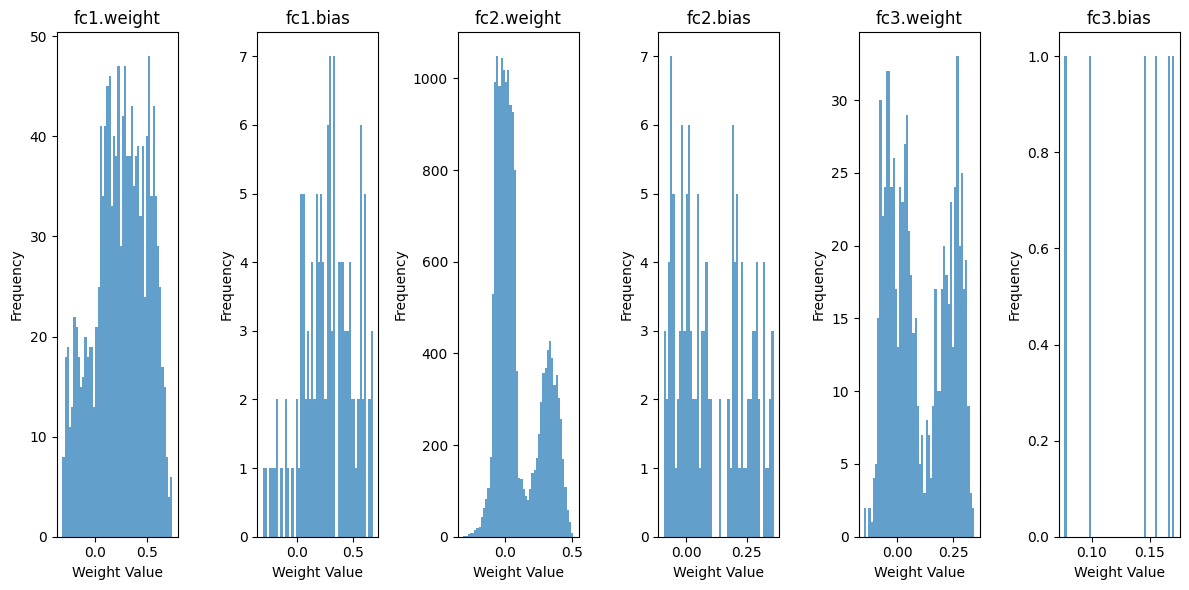

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from collections import deque
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/Synthetic_RL-Based_Spacecraft_Trajectory_Data.csv"  # Change this to your dataset file
rl_trajectory_df = pd.read_csv(file_path)

# Encode categorical columns
le_env = LabelEncoder()
le_action = LabelEncoder()
rl_trajectory_df["Environment"] = le_env.fit_transform(rl_trajectory_df["Environment"])
rl_trajectory_df["Action_Taken"] = le_action.fit_transform(rl_trajectory_df["Action_Taken"])

# Normalize numerical data
scaler = MinMaxScaler()
numeric_features = [
    "Initial_Altitude_km", "Final_Altitude_km", "Initial_Velocity_km_s",
    "Final_Velocity_km_s", "Fuel_Consumption_kg", "Thrust_Used_kN",
    "Delta_V_km_s", "Radiation_Exposure_Sv", "Navigation_Error_km", "Collision_Risk"
]
rl_trajectory_df[numeric_features] = scaler.fit_transform(rl_trajectory_df[numeric_features])

# Define state and action space
state_columns = ["Environment"] + numeric_features
action_column = "Action_Taken"
states = rl_trajectory_df[state_columns].values
actions = rl_trajectory_df[action_column].values
rewards = rl_trajectory_df["Reward"].values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
state_size = len(state_columns)
action_size = len(le_action.classes_)
dqn = DQN(state_size, action_size).to(device)
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Experience replay buffer
memory = deque(maxlen=2000)
batch_size = 64
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 500

# Training loop
for episode in range(num_episodes):
    batch_indices = np.random.choice(len(states), batch_size, replace=False)
    batch_states = torch.FloatTensor(states[batch_indices]).to(device)
    batch_actions = torch.LongTensor(actions[batch_indices]).to(device)
    batch_rewards = torch.FloatTensor(rewards[batch_indices]).to(device)

    q_values = dqn(batch_states)
    target_q_values = q_values.clone().detach()

    for i in range(batch_size):
        target_q_values[i][batch_actions[i]] = batch_rewards[i] + gamma * torch.max(q_values[i]).item()

    loss = criterion(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % 50 == 0:
        print(f"Episode {episode}/{num_episodes} - Loss: {loss.item():.4f}, Epsilon: {epsilon:.4f}")

# Save the trained model
torch.save(dqn.state_dict(), "/content/sample_data/dqn_spacecraft_trajectory.pth")
print("Model training complete and saved as 'dqn_spacecraft_trajectory.pth'")

# Load the trained model weights
model_path = "/content/sample_data/dqn_spacecraft_trajectory.pth"
dqn_model = DQN(state_size, action_size)  # Initialize model architecture
dqn_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Extract weights from the model
weights = {name: param.detach().numpy() for name, param in dqn_model.named_parameters()}

# Plot weight distributions for each layer
plt.figure(figsize=(12, 6))
for i, (layer_name, weight_values) in enumerate(weights.items()):
    plt.subplot(1, len(weights), i + 1)
    plt.hist(weight_values.flatten(), bins=50, alpha=0.7)
    plt.title(layer_name)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()